# XGBoost

## 1 Импорт библиотек, инициализация глобальных констант

### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import optuna

pd.set_option('display.max_columns', 50)
optuna.logging.set_verbosity(optuna.logging.WARNING)

### 1.2 Инициализация констант

In [2]:
# путь к папке с данными
path = Path('')
# название целевой переменной
TARGET_NAME = 'Approved'
# количество фолдов для кросс-валидации
N_FOLDS = 5
# random state для воспроизводимости
RANDOM_STATE = 42
# размер отложенной выборки
TEST_SIZE = 0.2

## 2 Подготовка данных

In [3]:
train = pd.read_csv(path / 'train_preprocessed.csv')
test = pd.read_csv(path / 'test_preprocessed.csv')
train

,ID,Gender,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,Loan_Amount_per_Period,Credit_pct,Credit_pct_per_Period,Amount_over_pct,Amount_plus_pct,Amount_plus_pct_per_period,Amount_plus_pct_over_amount,Amount_pct_per_period,Credit_over_income,Credit_pct_over_income,Monthly_Income_in_city,Monthly_Income_at_employer,Monthly_Income_in_source_category,Monthly_Income_over_city_income,Monthly_Income_over_employeer_income,Monthly_Income_over_category_income,Age
0,APPC90493171225,Female,C10001,A,another,A,4.0,2000.0,B001,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13461.737114,2000.000000,4517.348356,0.148569,1.000000,0.442738,36
1,APPD40611263344,Male,C10003,A,COM0000002,C,1.0,3500.0,B002,P,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0,10000.0,2650.0,1325.000,7.547170,22650.0,11325.000,1.1325,0.566250,2.857143,0.378571,4130.332287,4789.257987,4517.348356,0.847389,0.730802,0.774791,29
2,APPE70289249423,Male,another,C,another,C,4.0,2250.0,B003,G,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0,11250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,3668.495833,2250.000000,6218.750490,0.613330,1.000000,0.361809,33
3,APPF80273865537,Male,another,C,another,A,4.0,3500.0,B003,G,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0,18400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.257143,NaN,1525.000000,2700.000000,6218.750490,2.295082,1.296296,0.562814,27
4,APPG60994436641,Male,C10002,A,another,A,4.0,10000.0,B001,P,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000,NaN,4465.358272,6644.750000,6218.750490,2.239462,1.504948,1.608040,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,Female,C10006,A,COM0000010,A,1.0,4900.0,B002,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4042.877278,5781.724828,4517.348356,1.212008,0.847498,1.084707,33
69709,APPV80989824738,Female,another,C,another,A,4.0,7190.1,B002,P,N,S122,G,1450.0,NaN,NaN,NaN,NaN,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4886.480000,7190.100000,4517.348356,1.471427,1.000000,1.591664,45
69710,APPW50697209842,Female,C10022,B,another,C,4.0,1600.0,B030,P,Y,S122,G,0.0,24000.0,4.0,35.50,943.0,2,0,6000.0,8520.0,2130.000,2.816901,32520.0,8130.000,1.3550,0.338750,3.750000,1.331250,3472.887186,1625.000000,4517.348356,0.460712,0.984615,0.354190,24
69711,APPY50870035036,Male,C10002,A,another,C,3.0,9893.0,B002,P,Y,S122,G,1366.0,80000.0,5.0,NaN,NaN,10,0,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.617305,NaN,4465.358272,3265.884615,4517.348356,2.215500,3.029195,2.190002,38


### 2.1 Используемые признаки при обучении

In [4]:
# используемые признаки при обучении
features = [
    c for c in train.columns if c != 'ID' and c != 'Approved'
    and c != 'Monthly_Income_in_source_category'
]
# численные признаки
num_features = train.select_dtypes(
    include=[int, float]).nunique()[lambda x: x > 25].index
# категориальные признаки
cat_features = list(set(features) - set(num_features))

### 2.2 Отложенная выборка

In [5]:
tr_data, te_data = train_test_split(train,
                                    test_size=TEST_SIZE,
                                    random_state=RANDOM_STATE,
                                    stratify=train[TARGET_NAME])
tr_data = tr_data.reset_index(drop=True)
target = te_data[TARGET_NAME]

### 2.3 Предобработка категориальных признаков

In [6]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
tr_data[cat_features] = encoder.fit_transform(tr_data[cat_features])
te_data[cat_features] = encoder.transform(te_data[cat_features])

## 3 Вспомогательные функции

### 3.1 Функция для обучения модели

In [7]:
def xgb_training(train_df, params, test_df=None, verbose=True):
    """
    Функция для обучения модели.
    
    Параметры
    ----------
    train_df - обучающая выборка
    params - набор гиперпараметров
    test_df - тестовая выборка
    verbose - нужно ли выводить результаты
    
    Возвращает
    -------
    score_list - roc-auc на кросс-валидации для каждого фолда
    test_preds - предсказания на тестовой выборке, если тестовая выборка задана
    """
    test_preds = []
    if test_df is not None:
        test_preds = np.zeros(len(test_df))
        test_df = xgb.DMatrix(test_df[features])
    target = train_df.loc[:, TARGET_NAME].values

    score_list = []
    kf = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=RANDOM_STATE)
    for fold, (train_index, val_index) in enumerate(kf.split(train_df,
                                                             target)):
        X_train = train_df.loc[train_index, features]
        X_val = train_df.loc[val_index, features]
        y_train = target[train_index]
        y_val = target[val_index]
        dtrain = xgb.DMatrix(data=X_train, label=y_train)
        dvalid = xgb.DMatrix(data=X_val, label=y_val)

        model = xgb.train(params,
                          dtrain=dtrain,
                          evals=[(dtrain, 'train'), (dvalid, 'eval')],
                          num_boost_round=10000,
                          early_stopping_rounds=100,
                          verbose_eval=100 if verbose else 0)

        preds = model.predict(dvalid)
        score = roc_auc_score(y_val, preds)

        if test_df is not None:
            test_preds += model.predict(test_df) / kf.n_splits

        if verbose:
            print(
                f"{Fore.BLACK}{Style.BRIGHT}FOLD: {fold}, ROC-AUC: {score:.5f} {Style.RESET_ALL}"
            )
        score_list.append(score)

    return score_list, test_preds

## 4 Гиперпараметры по умолчанию

In [8]:
params = {
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': RANDOM_STATE,
    'eta': 0.03
}

In [9]:
oof_score, holdout_pred = xgb_training(tr_data, params, te_data)
print(
    f"{Fore.GREEN}{Style.BRIGHT}\nROC-AUC на кросс-валидации: {np.mean(oof_score):.5f} +- {np.std(oof_score):.5f}"
)
print(
    f"{Fore.RED}ROC-AUC на отложенной выборке: {roc_auc_score(te_data[TARGET_NAME],holdout_pred):.5f}{Style.RESET_ALL}"
)

[0]	train-auc:0.77715	eval-auc:0.74478
[100]	train-auc:0.91320	eval-auc:0.82994
[200]	train-auc:0.94143	eval-auc:0.83953
[300]	train-auc:0.95817	eval-auc:0.84457
[400]	train-auc:0.96862	eval-auc:0.84252
FOLD: 0, ROC-AUC: 0.84252 
[0]	train-auc:0.80107	eval-auc:0.78301
[100]	train-auc:0.91142	eval-auc:0.83058
[200]	train-auc:0.94494	eval-auc:0.84558
[300]	train-auc:0.95737	eval-auc:0.84943
[400]	train-auc:0.97018	eval-auc:0.84948
[417]	train-auc:0.97153	eval-auc:0.84953
FOLD: 1, ROC-AUC: 0.84951 
[0]	train-auc:0.79205	eval-auc:0.73888
[100]	train-auc:0.90745	eval-auc:0.81540
[200]	train-auc:0.94025	eval-auc:0.82998
[300]	train-auc:0.95362	eval-auc:0.83565
[400]	train-auc:0.96603	eval-auc:0.84065
[500]	train-auc:0.97497	eval-auc:0.84316
[598]	train-auc:0.98108	eval-auc:0.84061
FOLD: 2, ROC-AUC: 0.84066 
[0]	train-auc:0.79871	eval-auc:0.81892
[100]	train-auc:0.91481	eval-auc:0.84384
[200]	train-auc:0.94032	eval-auc:0.85625
[300]	train-auc:0.95316	eval-auc:0.85577
[318]	train-auc:0.95616	e

## 5 Оптимизация гиперпараметров

In [10]:
def xgb_objective(trial):
    params = {
        'eval_metric':
        'auc',
        'objective':
        'binary:logistic',
        'random_state':
        RANDOM_STATE,
        'grow_policy':
        trial.suggest_categorical('grow_policy', ['lossguide', 'depthwise']),
        'learning_rate':
        trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth':
        trial.suggest_int('max_depth', 3, 15),
        'reg_alpha':
        trial.suggest_float('reg_alpha', 0, 20),
        'reg_lambda':
        trial.suggest_float('reg_lambda', 0, 20),
        'min_child_weight':
        trial.suggest_int('min_child_weight', 1, 300),
        'colsample_bytree':
        trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample':
        trial.suggest_float('subsample', 0.5, 1.0),
        'scale_pos_weight':
        trial.suggest_int('scale_pos_weight', 1, 10)
    }
    if params['grow_policy'] == 'lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 1, 100)

    score, _ = xgb_training(tr_data, params, verbose=False)
    score = np.mean(score)

    return score

In [11]:
study = optuna.create_study(study_name="xgboost", direction='maximize')
study.optimize(xgb_objective, n_trials=25)

Посмотрим на подобранные гиперпараметры

In [12]:
study.best_params

{'grow_policy': 'depthwise',
 'learning_rate': 0.010924320909852823,
 'max_depth': 7,
 'reg_alpha': 0.30042952524701005,
 'reg_lambda': 17.251318265146846,
 'min_child_weight': 73,
 'colsample_bytree': 0.8800484431076853,
 'subsample': 0.7611038119933783,
 'scale_pos_weight': 8}

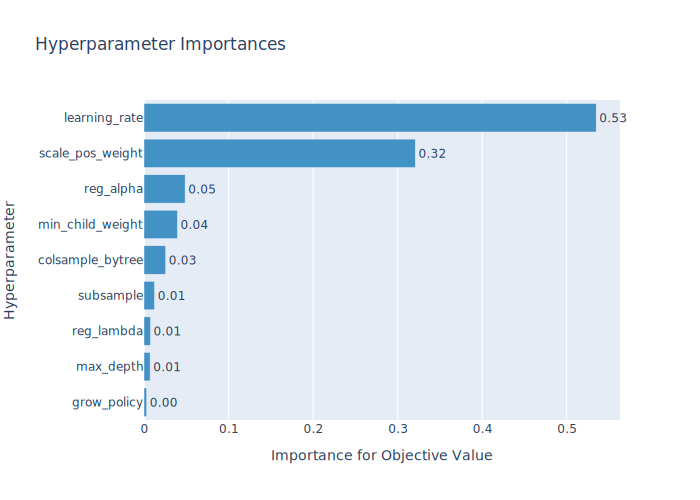

In [13]:
fig = optuna.visualization.plot_param_importances(study)
fig.show('svg')

Наибольшую важность имеют learning_rate и scale_pos_weight (думаю, этот параметр играет большую роль, поскольку классы не сбалансированы)

Значение метрики на отложенной выборке

In [14]:
params.update(study.best_params)
oof_score, holdout_pred = xgb_training(tr_data, params, te_data)
print(
    f"{Fore.GREEN}{Style.BRIGHT}\nROC-AUC на кросс-валидации: {np.mean(oof_score):.5f} +- {np.std(oof_score):.5f}"
)
print(
    f"{Fore.RED}ROC-AUC на отложенной выборке: {roc_auc_score(te_data[TARGET_NAME],holdout_pred):.5f}{Style.RESET_ALL}"
)

[0]	train-auc:0.82638	eval-auc:0.80137
[100]	train-auc:0.88721	eval-auc:0.84041
[200]	train-auc:0.90089	eval-auc:0.84444
[300]	train-auc:0.90972	eval-auc:0.84645
[400]	train-auc:0.91715	eval-auc:0.84816
[500]	train-auc:0.92357	eval-auc:0.84858
[600]	train-auc:0.93047	eval-auc:0.84760
[605]	train-auc:0.93073	eval-auc:0.84748
FOLD: 0, ROC-AUC: 0.84741 
[0]	train-auc:0.82302	eval-auc:0.78171
[100]	train-auc:0.88740	eval-auc:0.83455
[200]	train-auc:0.90221	eval-auc:0.84518
[300]	train-auc:0.91156	eval-auc:0.84902
[400]	train-auc:0.91877	eval-auc:0.85058
[500]	train-auc:0.92460	eval-auc:0.85200
[600]	train-auc:0.93142	eval-auc:0.85285
[700]	train-auc:0.93783	eval-auc:0.85300
[800]	train-auc:0.94371	eval-auc:0.85260
[812]	train-auc:0.94430	eval-auc:0.85252
FOLD: 1, ROC-AUC: 0.85246 
[0]	train-auc:0.81393	eval-auc:0.75020
[100]	train-auc:0.88806	eval-auc:0.82475
[200]	train-auc:0.90259	eval-auc:0.83357
[300]	train-auc:0.91133	eval-auc:0.83839
[400]	train-auc:0.91785	eval-auc:0.84164
[500]	tra

## 6 Сравнение результатов:

| Гиперпараметры | Кросс-валидация | Отложенная выборка |
| :--- | :--- | :--- |
| По умолчанию | 0.84696 | 0.83312 |
| Optuna | 0.85177 | 0.83738 |